In [8]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import os.path

In [9]:
def lineseg_dists(p, a, b):
    """Cartesian distance from point to line segment

    Edited to support arguments as series, from:
    https://stackoverflow.com/a/54442561/11208892

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """
    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

def lineseg_dist(p, a, b): 
    n_p = p.shape[0] 
    n_s = a.shape[0]

    p_s = np.tile(p, (n_s,1))
    a_s = np.tile(a, (1,n_p)).reshape((-1,2))
    b_s = np.tile(b, (1,n_p)).reshape((-1,2))
    
    dists = lineseg_dists(p_s, a_s, b_s)
    dists = dists.reshape((-1, n_p)).reshape((-1, n_p))
    dists = np.min(dists, axis=0)
    
    return dists


# p = np.array([[0,1],[0,2],[0,3],[0,4]])
# a = np.array([[1,1],[2,2],[3,3]])
# b = np.array([[2,2],[3,3],[4,4]])

# n_p = p.shape[0] 
# n_s = a.shape[0]

# p_s = np.tile(p, (n_s,1))
# a_s = np.tile(a, (1,n_p)).reshape((-1,2))
# b_s = np.tile(b, (1,n_p)).reshape((-1,2))

# dists = lineseg_dist(p, a, b)

In [10]:
pref_folder = "/groups/esm/dzhuang/Catheter/"

# Preprocess flow/geometry data 

In [10]:
flow_data_files =  glob.glob(pref_folder+"flowdata-meshgrid/*")

n_node_max = 8483
n_data = len(flow_data_files)
print(n_data)
assert(n_data == len(range(41,60,2))*len(range(41,60,2))*len(np.arange(2,6.6,0.5)))

x_1d_data_periodic = np.zeros((n_node_max, n_data))
x_1d_data_periodic[:] = np.NaN
y_1d_data_periodic = np.zeros((n_node_max, n_data))
y_1d_data_periodic[:] = np.NaN
u_1d_data_periodic = np.zeros((n_node_max, n_data))
u_1d_data_periodic[:] = np.NaN
v_1d_data_periodic = np.zeros((n_node_max, n_data))
v_1d_data_periodic[:] = np.NaN
vor_1d_data_periodic = np.zeros((n_node_max, n_data))
vor_1d_data_periodic[:] = np.NaN
wdist_1d_data_periodic = np.zeros((n_node_max, n_data))
wdist_1d_data_periodic[:] = np.NaN

#                   (x2, h)
#
#    40  θ_1           x3   θ_2
# x2 x3 h, θ_1 pressure, nnodes
info_1d_data = np.zeros((7, n_data))

pressure = loadmat(pref_folder+'pressure2.mat')["press_arr"].flatten()
n_node_max = 0
idx = 0
for x2 in range(41,60,2):
    for x3 in range(41,60,2):
        for h in np.arange(2,6.6,0.5):
            if h.is_integer():
                h = np.int64(h)
                
            file_name = pref_folder+"flowdata-meshgrid/L100W20flow_"+str(x2)+"_"+str(x3)+"_"+str(h)+".txt"
            file = open(file_name, "r")

            data = np.genfromtxt(file_name, dtype=float, skip_header=9)
            path = np.vstack(([0, 40.0, x2, x3, 100.0], [0, 0.0, h, 0, 0.0])).transpose()
            path_a, path_b = path[0:-1,:], path[1:,:]
            path = np.vstack(([0.0, 40.0, x2, x3, 100.0], [20.0, 20.0, 20.0-h, 20.0, 20.0])).transpose()
            path_a, path_b = np.vstack((path_a,path[0:-1,:])), np.vstack((path_b,path[1:,:]))

            x_1d = data[:,0] 
            y_1d = data[:,1] 
            u_1d = data[:,2] 
            v_1d = data[:,3] 
            vor_1d = data[:,4] 
            wdist_1d = lineseg_dist(np.vstack((x_1d, y_1d)).transpose(), path_a, path_b)
            
            
            
            n_active_1 = len(x_1d)
            
            x_1d_data_periodic[0:n_active_1,idx] = x_1d - 100
            y_1d_data_periodic[0:n_active_1,idx] = y_1d
            u_1d_data_periodic[0:n_active_1,idx] = u_1d
            v_1d_data_periodic[0:n_active_1,idx] = v_1d
            vor_1d_data_periodic[0:n_active_1,idx] = vor_1d
            wdist_1d_data_periodic[0:n_active_1,idx] = wdist_1d
            
            x_le_100_ind = x_1d < (100-0.1)
            n_active_2 = sum(x_le_100_ind)
            
            x_1d_data_periodic[n_active_1:n_active_1+n_active_2,idx] = x_1d[x_le_100_ind] 
            y_1d_data_periodic[n_active_1:n_active_1+n_active_2,idx] = y_1d[x_le_100_ind]
            u_1d_data_periodic[n_active_1:n_active_1+n_active_2,idx] = u_1d[x_le_100_ind]
            v_1d_data_periodic[n_active_1:n_active_1+n_active_2,idx] = v_1d[x_le_100_ind]
            vor_1d_data_periodic[n_active_1:n_active_1+n_active_2,idx] = vor_1d[x_le_100_ind]
            wdist_1d_data_periodic[n_active_1:n_active_1+n_active_2,idx] = wdist_1d[x_le_100_ind]
            
            
            
            n_active = n_active_1 + n_active_2
            info_1d_data[:, idx] = x2, x3, h, math.atan2(h, x2 - 40), math.atan2(h, x2 - x3),  pressure[idx], n_active

            n_node_max = max(n_node_max, n_active)
            idx += 1

print( n_node_max )

np.save(pref_folder+"x_1d_data_periodic.npy", x_1d_data_periodic)
np.save(pref_folder+"y_1d_data_periodic.npy", y_1d_data_periodic)
np.save(pref_folder+"u_1d_data_periodic.npy", u_1d_data_periodic)
np.save(pref_folder+"v_1d_data_periodic.npy", v_1d_data_periodic)
np.save(pref_folder+"vor_1d_data_periodic.npy", vor_1d_data_periodic)
np.save(pref_folder+"wdist_1d_data_periodic.npy", wdist_1d_data_periodic)


np.save(pref_folder+"info_1d_data.npy", info_1d_data)

1000
8483


In [6]:
flow_data_files = sorted(glob.glob(pref_folder+"flowdata/*"))

n_data = len(flow_data_files)
assert(n_data == len(range(41,60,2))*len(range(41,60,2))*len(np.arange(2,6.6,0.5)))
x_2d_data, y_2d_data = np.zeros((201, 1001, n_data)), np.zeros((201, 1001, n_data))
u_2d_data, v_2d_data, vor_2d_data = np.zeros((201, 1001, n_data)) , np.zeros((201, 1001, n_data)) , np.zeros((201, 1001, n_data)) 
wdist_2d_data = np.zeros((201, 1001, n_data))

#                   (x2, h)
#
#    40  θ_1           x3   θ_2
# x2 x3 h, θ_1 pressure, nnodes
info_2d_data = np.zeros((7, n_data))

pressure = loadmat(pref_folder+"pressure2.mat")["press_arr"].flatten()

idx = 0
for x2 in range(41,60,2):
    for x3 in range(41,60,2):
        for h in np.arange(2,6.6,0.5):
            
            if h.is_integer():
                h = np.int64(h)
                
            file_name = pref_folder+"flowdata/flow_"+str(x2)+"_"+str(x3)+"_"+str(h)+".txt"
            file = open(file_name, "r")

            data = np.genfromtxt(file_name, dtype=float, skip_header=9)
            path = np.vstack(([0, 40.0, x2, x3, 100.0], [0, 0.0, h, 0, 0.0])).transpose()

            x_2d = data[:,0] 
            y_2d = data[:,1] 
            u_2d = data[:,2] 
            v_2d = data[:,3] 
            vor_2d = data[:,4] 
            active_ind = ~np.isnan(data[:,2])
            path_a, path_b = path[0:-1,:], path[1:,:]
            wdist_2d = lineseg_dist(np.vstack((x_2d, y_2d)).transpose(), path_a, path_b)
            
            wdist_2d[~active_ind] = -wdist_2d[~active_ind]

            x_2d_data[:,:,idx] = x_2d.reshape((201, 1001))
            y_2d_data[:,:,idx] = y_2d.reshape((201, 1001))
            u_2d_data[:,:,idx] = u_2d.reshape((201, 1001))
            v_2d_data[:,:,idx] = v_2d.reshape((201, 1001))
            vor_2d_data[:,:,idx] = vor_2d.reshape((201, 1001))
            
            wdist_2d = wdist_2d.reshape((201, 1001))
            wdist_2d[100:,:] = wdist_2d[100::-1,:]
            wdist_2d_data[:,:,idx] = wdist_2d
            
            n_active = sum(active_ind)
            info_2d_data[:, idx] = x2, x3, h, math.atan2(h, x2 - 40), math.atan2(h, x2 - x3),  pressure[idx], n_active

         
            idx += 1
            

            
x_2d_data_periodic, y_2d_data_periodic = np.zeros((201, 2001, n_data)), np.zeros((201, 2001, n_data))
u_2d_data_periodic, v_2d_data_periodic, vor_2d_data_periodic = np.zeros((201, 2001, n_data)) , np.zeros((201, 2001, n_data)) , np.zeros((201, 2001, n_data)) 
wdist_2d_data_periodic = np.zeros((201, 2001, n_data))


x_2d_data_periodic[:, 0:1001] = x_2d_data - 100.0
y_2d_data_periodic[:, 0:1001] = y_2d_data
u_2d_data_periodic[:, 0:1001] = u_2d_data
v_2d_data_periodic[:, 0:1001] = v_2d_data
vor_2d_data_periodic[:, 0:1001] = vor_2d_data
wdist_2d_data_periodic[:, 0:1001] = wdist_2d_data

x_2d_data_periodic[:, 1000:] = x_2d_data 
y_2d_data_periodic[:, 1000:] = y_2d_data
u_2d_data_periodic[:, 1000:] = u_2d_data
v_2d_data_periodic[:, 1000:] = v_2d_data
vor_2d_data_periodic[:, 1000:] = vor_2d_data
wdist_2d_data_periodic[:, 1000:] = wdist_2d_data


np.save(pref_folder+"x_2d_data_periodic.npy", x_2d_data_periodic)
np.save(pref_folder+"y_2d_data_periodic.npy", y_2d_data_periodic)
np.save(pref_folder+"u_2d_data_periodic.npy", u_2d_data_periodic)
np.save(pref_folder+"v_2d_data_periodic.npy", v_2d_data_periodic)
np.save(pref_folder+"vor_2d_data_periodic.npy", vor_2d_data_periodic)
np.save(pref_folder+"wdist_2d_data_periodic.npy", wdist_2d_data_periodic)


np.save(pref_folder+"info_2d_data.npy", info_2d_data)

/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_2.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_2.5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_3.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_3.5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_4.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_4.5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_5.5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_6.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_41_6.5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_43_2.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_43_2.5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_43_3.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_43_3.5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_43_4.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_43_4.5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_43_5.txt
/groups/esm/dzhuang/Catheter/flowdata/flow_41_43_

# Preprocess bacteria data 

In [ ]:
# import h5py

# n_data = len(range(41,60,2))*len(range(41,60,2))*len(np.arange(2,6.6,0.5))

# density_data = np.zeros((2001, 500, n_data))
# dx = 0.1
# nc = 1000
# nbins = 2*nc + 1
# dx = 100/nc
# myrange = (-100-dx/2, 100+dx/2)

# idx = 0
# for x2 in range(41,60,2):
#     for x3 in range(41,60,2):
#         for h in np.arange(2,6.6,0.5):
#             if h.is_integer():
#                 h = np.int64(h)
#             file_names = glob.glob(pref_folder+"traindata/"+str(x2)+"_"+str(x3)+"_"+str(h)+".h5")
#             if len(file_names) == 1 and os.path.exists(file_names[0]):
#                 hf = h5py.File(file_names[0], "r")
#                 for t in range(500):
#                     x_b = hf["config"][str(t+1)]["x"][:]
#                     density_data[:, t, idx] = np.histogram(x_b + 99, bins=nbins, range=myrange)[0];
#             else:
#                 print("warning: cannot find " + "*_" + str(x2) + "_" + str(x3) + "_" + str(h)+".h5")
                    
#             idx += 1

# np.save(pref_folder+"density_data.npy", density_data)

In [80]:
import h5py

n_data = len(range(41,60,2))*len(range(41,60,2))*len(np.arange(2,6.6,0.5))

# density 
nc = 1000
nbins = 2*nc + 1
dx = 100/nc
myrange = (-100-dx/2, 100+dx/2)
xx = np.linspace(-100,100, nbins)
    
    
bacteria_1d_data = np.zeros((10000, n_data))
density_1d_data = np.zeros((2001, n_data))
density_1d_raw_data = np.zeros((2001, n_data))
# change t
t = 499
# change bw_method for scipy.stats.gaussian_kde
bw_method = 5e-2


idx = 0
for x2 in range(41,60,2):
    for x3 in range(41,60,2):
        for h in np.arange(2,6.6,0.5):
            if h.is_integer():
                h = np.int64(h)
            file_names = glob.glob(pref_folder+"traindata/"+str(x2)+"_"+str(x3)+"_"+str(h)+".h5")
            if len(file_names) == 1 and os.path.exists(file_names[0]):
                hf = h5py.File(file_names[0], "r")
                
                x_b = hf["config"][str(t+1)]["x"][:]
                bacteria_1d_data[:,  idx] = x_b + 99
                
                bacteria_bin = np.histogram(bacteria_1d_data[:,  idx], bins=nbins, range=myrange)[0]
                density_1d_raw_data[:, idx] =  bacteria_bin
                kernel = stats.gaussian_kde(bacteria_1d_data[:,  idx], bw_method = bw_method)
                density_1d_data[:, idx] = kernel(xx)*sum(bacteria_bin)*dx
            else:
                print("warning: cannot find " + "*_" + str(x2) + "_" + str(x3) + "_" + str(h)+".h5")
                    
            idx += 1

np.save(pref_folder+"bacteria_1d_data.npy", bacteria_1d_data)
np.save(pref_folder+"density_1d_data.npy", density_1d_data)
np.save(pref_folder+"density_1d_raw_data.npy", density_1d_raw_data)

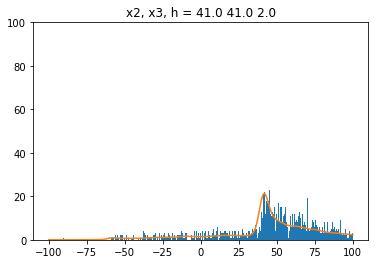

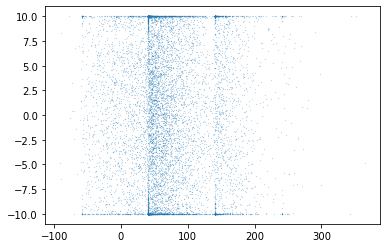

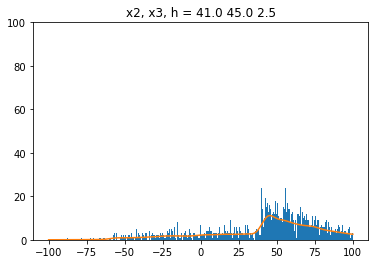

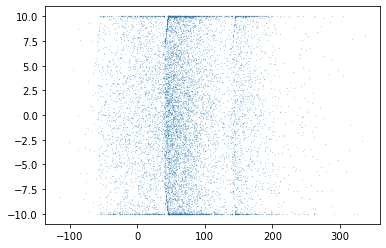

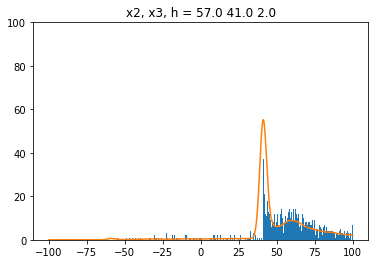

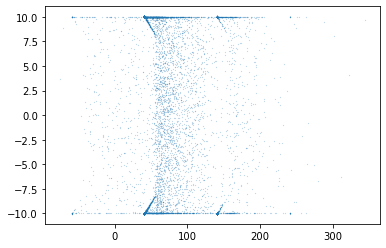

In [81]:
# Study the effect of bw_method
bw_method = 5e-2

from scipy import stats
bacteria_1d_data = np.load(pref_folder+"bacteria_1d_data.npy")
info_1d_data = np.load(pref_folder+"info_1d_data.npy")

dx = 0.1
nc = 1000
nbins = 2*nc + 1
dx = 100/nc
myrange = (-100-dx/2, 100+dx/2)
xx = np.linspace(-100,100, nbins)
# check t is consistent with data
t = 499

for sample_id in [0, 21, 800]:
    bacteria = bacteria_1d_data[:, sample_id]
    x2, x3, h, _, _, _, _ = info_1d_data[:, sample_id]
    # density 
    
    plt.figure()
    plt.hist(bacteria, bins=nbins, range=myrange)
    bacteria_bin = np.histogram(bacteria, bins=nbins, range=myrange)[0]
    kernel = stats.gaussian_kde(bacteria, bw_method = bw_method)
    plt.plot(xx,  kernel(xx)*sum(bacteria_bin)*dx)
    plt.ylim(0, 100)
    plt.title("x2, x3, h = "+ str(x2) + " " + str(x3) + " " + str(h) )
    
    
    x2, x3 = np.int64(x2), np.int64(x3)
    if h.is_integer():
        h = np.int64(h)
    file_names = glob.glob(pref_folder+"traindata/"+str(x2)+"_"+str(x3)+"_"+str(h)+".h5")
    hf = h5py.File(file_names[0], "r")
    x_b = hf["config"][str(t+1)]["x"][:]
    y_b = hf["config"][str(t+1)]["y"][:]
    plt.figure()
    plt.scatter(x_b +99, y_b, s=0.01)
    
